In [5]:
# extract all flights info over all nodes
import pandas as pd
import re

def parse_log_file(file_path):
    data = []
    current_flight = {}
    
    with open(file_path, 'r') as file:
        for line in file:
            line = line.strip()
            
            if line.startswith('***'):
                if current_flight:
                    data.append(current_flight)
                current_flight = {}
            elif line.startswith('node='):
                current_flight['node'] = int(line.split('=')[1])
            elif line.startswith('Callsign:'):
                current_flight['callsign'] = line.split(': ')[1]
            elif line.startswith('Entry number:'):
                current_flight['entry_number'] = int(line.split(': ')[1])
            elif line.startswith('Entry time:'):
                current_flight['entry_time'] = float(line.split(': ')[1])
            elif line.startswith('Speed in:'):
                current_flight['speed_in'] = float(line.split(': ')[1])
            elif line.startswith('tIn='):
                match = re.match(r'tIn=(\d+\.\d+)\s+tOut=(\d+\.\d+)', line)
                if match:
                    t_in = float(match.group(1))
                    t_out = float(match.group(2))
                    current_flight['event_time'] = (t_in + t_out) / 2
    
    if current_flight:
        data.append(current_flight)
    
    return pd.DataFrame(data)

# Usage
log_file_path = 'node_events.log'  # Replace with your actual file path
df = parse_log_file(log_file_path)

# Remove duplicate rows
df = df.drop_duplicates()

# Display the first few rows of the DataFrame
print(df.head())



# Save the DataFrame to a CSV file (optional)
df.to_csv('processed_log.csv', index=False)

   node   callsign  entry_number    entry_time    speed_in    event_time
0     8  ADD8633_1             0  74566.723174  179.026667  74566.723174
1     1  ADD8633_1             0  74566.723174  179.026667  74656.260350
2     2  ADD8633_1             0  74566.723174  179.026667  74905.169410
3     7  ADD8633_1             0  74566.723174  179.026667  75301.025899
4    17  ADD8633_1             0  74566.723174  179.026667  75358.523571


# Visualization Code (making a gif)

In [11]:
%matplotlib notebook

Number of conflicts is:  487


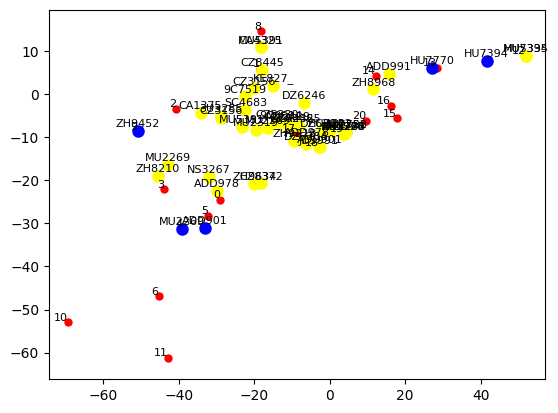

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation
import matplotlib.colors as mcolors


# Read node coordinates
nodes = {}
with open('DATA/SHEN_ZHEN/ZGSZ_PMS.nodes', 'r') as f:
    for i, line in enumerate(f, 1):
        x, y, _ = map(float, line.split())
        nodes[i-1] = (x, y)

# Read flight data
df = pd.read_csv('processed_log.csv')
# df['event_time'] = pd.to_datetime(df['event_time'], unit='s')

# Get unique callsigns
callsigns = df['callsign'].unique()

# Set up the plot
fig, ax = plt.subplots()
ax.set_xlim(min(x for x, _ in nodes.values()) - 5, max(x for x, _ in nodes.values()) + 5)
ax.set_ylim(min(y for _, y in nodes.values()) - 5, max(y for _, y in nodes.values()) + 5)

# Plot nodes
for node, (x, y) in nodes.items():
    ax.plot(x, y, 'ro', markersize=5)
    ax.text(x, y, str(node), fontsize=8, ha='right', va='bottom')

# Initialize aircraft positions and labels
aircraft = {}
labels = {}
for callsign in callsigns:
    aircraft[callsign] = ax.plot([], [], 'bo', markersize=8, label=callsign)[0]
    labels[callsign] = ax.text(0, 0, callsign, fontsize=8, ha='center', va='bottom')

# Function to calculate distance between two points
def calculate_distance(x1, y1, x2, y2):
    return np.sqrt((x2 - x1)**2 + (y2 - y1)**2)


n_conflicts = 0 
# Animation update function
def update(frame):
    global n_conflicts
    # current_time = pd.Timestamp(12 * 3600, unit='s') + pd.Timedelta(seconds=frame * 5)
    current_time = 12 * 3600 + frame * 5 # seconds
    aircraft_positions = {}

    for callsign in callsigns:
        flight_data = df[df['callsign'] == callsign]
        if flight_data.empty or current_time < flight_data['event_time'].min():
            aircraft[callsign].set_data([], [])
            labels[callsign].set_position((0, 0))
            labels[callsign].set_text('')
            continue
        
        last_event_time = flight_data['event_time'].max()
        if current_time > last_event_time + 10:
            aircraft[callsign].set_data([], [])
            labels[callsign].set_position((0, 0))
            labels[callsign].set_text('')
            continue
        
        current_node = flight_data[flight_data['event_time'] <= current_time].iloc[-1]
        next_node = flight_data[flight_data['event_time'] > current_time].iloc[0] if current_time < flight_data['event_time'].max() else None

        # if current_node is 2 and next_node is 7, then it may travel on the PMS arc
        if current_node['node'] == 2 and next_node['node'] == 7 and False:
            xm2, ym2 = nodes[current_node['node']] # nautical miles
            xm7, ym7 = nodes[next_node['node']] # nautical miles
            tm7 = next_node['event_time'] # pandas timestamp
            tm2 = current_node['event_time'] # pandas timestamp

            # tm7_minus_tm2 = tm7 - tm2
            # Convert tm7_minus_tm2 to hours
            # tm7_minus_tm2 = tm7_minus_tm2.total_seconds() / 3600
            
            vm = current_node['speed_in'] # knots
            r_PMS = np.linalg.norm([xm2 - xm7, ym2 - ym7]) # nautical miles
            t_travel_on_arc = tm7 - tm2 - r_PMS / vm # hours
            s_travel_on_arc = vm * t_travel_on_arc # nautical miles
            xt = xm7 + r_PMS * np.cos(np.arctan2(ym7 - ym2, xm7 - xm2) + s_travel_on_arc / r_PMS) # nautical miles
            yt = ym7 + r_PMS * np.sin(np.arctan2(ym7 - ym2, xm7 - xm2) + s_travel_on_arc / r_PMS) # nautical miles
            
            t_elapsed = current_time - tm2
            if t_elapsed < t_travel_on_arc:
                # The plane is on the PMS arc
                progress = t_elapsed / t_travel_on_arc
                x = xm2 + r_PMS * np.cos(np.arctan2(ym7 - ym2, xm7 - xm2) + progress * s_travel_on_arc / r_PMS)
                y = ym2 + r_PMS * np.sin(np.arctan2(ym7 - ym2, xm7 - xm2) + progress * s_travel_on_arc / r_PMS)
            else:
                # The plane is flying towards node 7
                progress = (t_elapsed - t_travel_on_arc) / (tm7 - tm2 - t_travel_on_arc)
                x = xt + progress * (xm7 - xt)
                y = yt + progress * (ym7 - yt)
        
        else:
            # If it is not a PMS arc
            if next_node is not None:
                progress = (current_time - current_node['event_time']) / (next_node['event_time'] - current_node['event_time'])
                x1, y1 = nodes[current_node['node']]
                x2, y2 = nodes[next_node['node']]
                x = x1 + progress * (x2 - x1)
                y = y1 + progress * (y2 - y1)
            else:
                x, y = nodes[current_node['node']]
        
        aircraft_positions[callsign] = (x, y)
        
        aircraft[callsign].set_data([x], [y])
        labels[callsign].set_position((x, y + 0.5))  # Position the label slightly above the aircraft
        if callsign == ''
        labels[callsign].set_text(callsign[0:6])

    # Check for conflicts and update colors
    
    for callsign1, pos1 in aircraft_positions.items():
        conflict = False
        for callsign2, pos2 in aircraft_positions.items():
            if callsign1 != callsign2:
                distance = calculate_distance(*pos1, *pos2)
                if distance < 5.556:  #  nautical miles in kilometers
                    conflict = True
                    n_conflicts += 1
                    break
        
        color = 'yellow' if conflict else 'blue'
        aircraft[callsign1].set_color(color)
    
    return list(aircraft.values()) + list(labels.values())

# Create animation
animation = FuncAnimation(fig, update, frames=10,
                          interval=10, blit=True)

# Import the necessary writer
from matplotlib.animation import PillowWriter

# Set up the Pillow writer for GIF
writer = PillowWriter(fps=5)

# Save the animation as a GIF file
animation.save('aircraft_movement.gif', writer=writer)

print('Number of conflicts is: ', n_conflicts)


# plt.legend()
# plt.title('Aircraft Movement Animation')
# plt.show()

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation

# Create a figure and axis
fig, ax = plt.subplots()

# Initialize an empty line
line, = ax.plot([], [])

# Set the plot limits
ax.set_xlim(0, 2*np.pi)
ax.set_ylim(-1, 1)

# Update function
def update(frame):
    # Generate x values
    print('Frame: ', frame)
    x = np.linspace(0, 2*np.pi, 100)
    
    # Generate y values (a sine wave that changes frequency over time)
    y = np.sin(frame * x)
    
    # Update the line data
    line.set_data(x, y)
    
    # Add a text annotation to show the current frame
    ax.set_title(f'Frame: {frame:.2f}')
    
    return line,

# Create animations with different frame configurations

# 1. Simple range (0, 1, 2, ..., 99)
anim1 = FuncAnimation(fig, update, frames=100, interval=50, blit=True)

# Choose which animation to display (uncomment one of the following lines)
# anim1.save('animation1.gif', writer='pillow', fps=30)
# anim2.save('animation2.gif', writer='pillow', fps=30)
# anim3.save('animation3.gif', writer='pillow', fps=30)

plt.show()

# Visualization Code of PBN-STD (making a gif)

In [ ]:
%matplotlib notebook

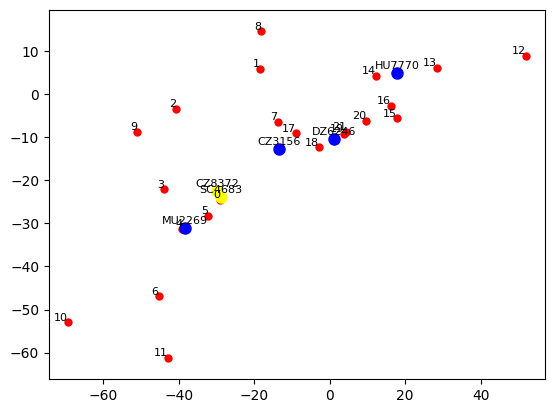

In [32]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation
import matplotlib.colors as mcolors


# Read node coordinates
nodes = {}
with open('DATA/SHEN_ZHEN/ZGSZ_PMS.nodes', 'r') as f:
    for i, line in enumerate(f, 1):
        x, y, _ = map(float, line.split())
        nodes[i-1] = (x, y)

# Read flight data
df = pd.read_csv('processed_log.csv')
df['event_time'] = pd.to_datetime(df['event_time'], unit='s')

# Get unique callsigns
callsigns = df['callsign'].unique()

# Set up the plot
fig, ax = plt.subplots()
ax.set_xlim(min(x for x, _ in nodes.values()) - 5, max(x for x, _ in nodes.values()) + 5)
ax.set_ylim(min(y for _, y in nodes.values()) - 5, max(y for _, y in nodes.values()) + 5)

# Plot nodes
for node, (x, y) in nodes.items():
    ax.plot(x, y, 'ro', markersize=5)
    ax.text(x, y, str(node), fontsize=8, ha='right', va='bottom')

# Initialize aircraft positions and labels
aircraft = {}
labels = {}
for callsign in callsigns:
    aircraft[callsign] = ax.plot([], [], 'bo', markersize=8, label=callsign)[0]
    labels[callsign] = ax.text(0, 0, callsign, fontsize=8, ha='center', va='bottom')

# Function to calculate distance between two points
def calculate_distance(x1, y1, x2, y2):
    return np.sqrt((x2 - x1)**2 + (y2 - y1)**2)

# Animation update function
def update(frame):
    current_time = pd.Timestamp(12 * 3600, unit='s') + pd.Timedelta(seconds=frame * 5)
    aircraft_positions = {}

    for callsign in callsigns:
        flight_data = df[df['callsign'] == callsign]
        if flight_data.empty or current_time < flight_data['event_time'].min():
            aircraft[callsign].set_data([], [])
            labels[callsign].set_position((0, 0))
            labels[callsign].set_text('')
            continue
        
        last_event_time = flight_data['event_time'].max()
        if current_time > last_event_time + pd.Timedelta(seconds=10):
            aircraft[callsign].set_data([], [])
            labels[callsign].set_position((0, 0))
            labels[callsign].set_text('')
            continue
        
        current_node = flight_data[flight_data['event_time'] <= current_time].iloc[-1]
        next_node = flight_data[flight_data['event_time'] > current_time].iloc[0] if current_time < flight_data['event_time'].max() else None
        
        if next_node is not None:
            progress = (current_time - current_node['event_time']) / (next_node['event_time'] - current_node['event_time'])
            x1, y1 = nodes[current_node['node']]
            x2, y2 = nodes[next_node['node']]
            x = x1 + progress * (x2 - x1)
            y = y1 + progress * (y2 - y1)
        else:
            x, y = nodes[current_node['node']]
        
        aircraft_positions[callsign] = (x, y)
        
        aircraft[callsign].set_data([x], [y])
        labels[callsign].set_position((x, y + 0.5))  # Position the label slightly above the aircraft
        labels[callsign].set_text(callsign[0:6])

    # Check for conflicts and update colors
    for callsign1, pos1 in aircraft_positions.items():
        conflict = False
        for callsign2, pos2 in aircraft_positions.items():
            if callsign1 != callsign2:
                distance = calculate_distance(*pos1, *pos2)
                if distance < 11.112:  #  nautical miles in 3 kilometers
                    conflict = True
                    break
        
        color = 'yellow' if conflict else 'blue'
        aircraft[callsign1].set_color(color)
    
    return list(aircraft.values()) + list(labels.values())

# Create animation
animation = FuncAnimation(fig, update, frames=20,
                          interval=10, blit=True)

# Import the necessary writer
from matplotlib.animation import PillowWriter

# Set up the Pillow writer for GIF
writer = PillowWriter(fps=5)

# Save the animation as a GIF file
animation.save('aircraft_movement.gif', writer=writer)


# plt.legend()
# plt.title('Aircraft Movement Animation')
# plt.show()

Calculate total flight time of all flights

In [18]:
import csv
from collections import defaultdict

def process_file(file_path):
    callsign_times = defaultdict(list)
    total_flight_time = 0
    skipped_rows = 0

    with open(file_path, 'r') as file:
        csv_reader = csv.DictReader(file)
        for row in csv_reader:
            callsign = row['callsign']
            try:
                event_time = float(row['event_time'])
                callsign_times[callsign].append(event_time)
            except ValueError:
                skipped_rows += 1
                continue

    for callsign, times in callsign_times.items():
        if len(times) < 2:
            print(f"Skipping callsign {callsign}: not enough time points")
            continue
        first_time = min(times)
        last_time = max(times)
        flight_time = last_time - first_time  # This is now in seconds
        total_flight_time += flight_time
        print(f"Callsign: {callsign}, Flight Time: {flight_time:.2f} seconds")

    print(f"Total Flight Time: {total_flight_time:.2f} seconds")
    print(f"Skipped rows due to invalid event_time: {skipped_rows}")

# Usage
process_file('/Users/apple/Desktop/SHEN_ZHEN Code Developement/Aft 1st Revision by Pr.D/SOFT_LIWEI_3_JavaDemandScalerR1_Run!=demands/processed_log.csv')

Callsign: ADD8633_1, Flight Time: 457.63 seconds
Callsign: CZ3174_342206c3.csv_1, Flight Time: 583.17 seconds
Callsign: CZ3562_3421d5ba.csv, Flight Time: 677.60 seconds
Callsign: OQ2065_3421683b.csv_1, Flight Time: 703.31 seconds
Callsign: ADD9084, Flight Time: 695.36 seconds
Callsign: ADD9015_1, Flight Time: 663.09 seconds
Callsign: CZ3436_3421b4b8.csv_1, Flight Time: 736.65 seconds
Callsign: CZ6588_3421746a.csv_1, Flight Time: 463.47 seconds
Callsign: CZ6642_34224fa4.csv, Flight Time: 555.51 seconds
Callsign: DZ6278_3420deed.csv, Flight Time: 494.06 seconds
Callsign: ZH9504_34217cae.csv, Flight Time: 673.13 seconds
Callsign: ADD8024, Flight Time: 457.51 seconds
Callsign: ADD5996, Flight Time: 940.98 seconds
Callsign: MU5243_3421a332.csv, Flight Time: 689.05 seconds
Callsign: MU6421_3421b75a.csv, Flight Time: 718.16 seconds
Callsign: ADD9415, Flight Time: 784.15 seconds
Callsign: ZH9024_3421cb08.csv, Flight Time: 826.00 seconds
Callsign: ZH9436_342112bd.csv_1, Flight Time: 760.41 seco

In [27]:
import csv
from collections import defaultdict

def process_file(file_path):
    callsign_times = defaultdict(list)
    total_flight_time = 0
    skipped_rows = 0
    skipped_callsigns = set()

    with open(file_path, 'r') as file:
        csv_reader = csv.DictReader(file)
        for row in csv_reader:
            callsign = row['callsign']
            event_time = row['event_time']
            
            if not event_time:  # Skip if event_time is empty
                skipped_rows += 1
                skipped_callsigns.add(callsign)
                continue
            
            try:
                event_time = float(event_time)
                callsign_times[callsign].append(event_time)
            except ValueError:
                skipped_rows += 1
                skipped_callsigns.add(callsign)
                continue

    for callsign, times in callsign_times.items():
        if len(times) < 2 or callsign in skipped_callsigns:
            skipped_callsigns.add(callsign)
            continue
        first_time = min(times)
        last_time = max(times)
        flight_time = last_time - first_time  # This is now in seconds
        total_flight_time += flight_time
        print(f"Callsign: {callsign}, Flight Time: {flight_time:.2f} seconds")

    print(f"\nTotal Flight Time: {total_flight_time:.2f} seconds")
    print(f"Skipped rows due to invalid or empty event_time: {skipped_rows}")
    print(f"Number of skipped callsigns due to incomplete data: {len(skipped_callsigns)}")
    print("Skipped callsigns:")
    for callsign in sorted(skipped_callsigns):
        print(f"  - {callsign}")

# Usage
process_file('/Users/apple/Desktop/SHEN_ZHEN Code Developement/Aft 1st Revision by Pr.D/SOFT_LIWEI_3_JavaDemandScalerR1_Run!=demands/processed_log.csv')

Callsign: MU6669, Flight Time: 495.69 seconds
Callsign: ZH9918, Flight Time: 649.55 seconds
Callsign: ZH9958, Flight Time: 741.28 seconds
Callsign: DZ6270, Flight Time: 519.79 seconds
Callsign: CZ3226, Flight Time: 755.54 seconds
Callsign: CZ5368_341f745a.csv, Flight Time: 554.44 seconds
Callsign: HO1946_341f731b.csv, Flight Time: 788.39 seconds
Callsign: ZH9308_341f70cc.csv, Flight Time: 490.82 seconds
Callsign: 9C6522_341f35c4.csv, Flight Time: 666.53 seconds
Callsign: KY3092_341f8c24.csv, Flight Time: 917.23 seconds
Callsign: CZ8646_341f0100.csv, Flight Time: 489.22 seconds
Callsign: ZH9930_341f62e6.csv, Flight Time: 497.34 seconds
Callsign: 9C6482_341f53a5.csv, Flight Time: 502.35 seconds
Callsign: HU7760_341f63ab.csv, Flight Time: 499.00 seconds
Callsign: HO1948_341f1ff3.csv, Flight Time: 512.67 seconds
Callsign: ZH9630_341f79ad.csv, Flight Time: 500.67 seconds
Callsign: UQ2615_341f1322.csv, Flight Time: 718.68 seconds
Callsign: 9C7550_341f905a.csv, Flight Time: 723.26 seconds
Cal